# Wk18 Lecture02 CodeAlong: UFOs

## Learning Objectives

- By the end of this CodeAlong, students will be able to:
   - Calculate time series statistics (rolling mean/std/diff/pct_change

    

# 🕹️Part 1) Preparing Irregular-Interval Time Series

### Overview from Last Lecture

- 1) [ ] Convert the dates & times to a single column (if needed).
- 2) [ ] Convert the datetime column  (most likely a string) to a datetime data type.
- 3) [ ] Set the datetime column as the Series/DataFrame index
- 4) [ ] Resample the time series to the desired/correct frequency using the desired/correct aggregation method.
- 5) [ ] Impute null values (if required)


### UFO Sightings

- UFO Sightings: https://www.kaggle.com/datasets/NUFORC/ufo-sightings 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticks
import seaborn as sns


import missingno as miss
import datetime as dt
import statsmodels.tsa.api as tsa

In [2]:
ufo  = pd.read_csv("Data/ufos-kaggle/scrubbed.csv", low_memory=False)
ufo.head(3)

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667


In [3]:
ufo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              80332 non-null  object 
 1   city                  80332 non-null  object 
 2   state                 74535 non-null  object 
 3   country               70662 non-null  object 
 4   shape                 78400 non-null  object 
 5   duration (seconds)    80332 non-null  object 
 6   duration (hours/min)  80332 non-null  object 
 7   comments              80317 non-null  object 
 8   date posted           80332 non-null  object 
 9   latitude              80332 non-null  float64
 10  longitude             80332 non-null  float64
dtypes: float64(2), object(9)
memory usage: 6.7+ MB


>- 1) [x] Convert the dates & times to a single column (if needed).

## Preparing the Datetime Index

## 1. All Dates and Times in One Row:

This is already true here; nothing to change.

## 2. Converting Date Cols to Datetime

In [4]:
## Investigate the date format
ufo.loc[0,'datetime']

'10/10/1949 20:30'

In [5]:
## Set the date format
fmt = '%m/%d/%Y %H:%M'

In [7]:
## convert datetime to datetime
# ufo['datetime'] = pd.to_datetime(ufo['datetime'], format=fmt)

### Handling Errors with pd.to_datetime

- Can use the `errors` argument for pd.to_datetime:
    - "raise" (default): raise an exception when errors happen
    - 'ignore': ignores the errors and returns the original value for that row. 
        - NOT RECOMMENDED: the entire column will not be datetime.
    - 'coerce': convert any bad datetime values to null values (NaT - NotATime)

>- **Branch point: we have a choice on how we deal with the bad timestamps.**
    -  Do we coerce them, make then null values, and drop them? Potentially losing a lot of data.
    - Or do we investigate a bit more to see if we can fix the problem without losing data.
    
    
- Let's see how much data we would lose if we chose to coerce the bad values:

In [8]:
ufo[ufo['datetime'].str.contains('24:00')].shape

(694, 11)

In [9]:
##check nulls before coercing errors
ufo.isna().sum()

datetime                   0
city                       0
state                   5797
country                 9670
shape                   1932
duration (seconds)         0
duration (hours/min)       0
comments                  15
date posted                0
latitude                   0
longitude                  0
dtype: int64

In [10]:
## Check missing data after coerce
coerced_dt = pd.to_datetime(ufo["datetime"], format=fmt, errors='coerce')
coerced_dt.isna().sum() / len(ufo)

0.008639147537718469

Should we drop the rows, or try to fix the times?

In [11]:
## Drop the rows



In [12]:
## Fix the errors: 
ufo['datetime'] = ufo['datetime'].str.replace('24:00', '23:59')
ufo['datetime'] = pd.to_datetime(ufo['datetime'], format=fmt)

In [13]:
ufo.dtypes

datetime                datetime64[ns]
city                            object
state                           object
country                         object
shape                           object
duration (seconds)              object
duration (hours/min)            object
comments                        object
date posted                     object
latitude                       float64
longitude                      float64
dtype: object

## 3. Setting datetime index

In [14]:
ufo_ts = ufo.set_index('datetime')
ufo_ts

,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
datetime,,,,,,,,,,
1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111
1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082
1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667
1956-10-10 21:00:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833
1960-10-10 20:00:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611
...,...,...,...,...,...,...,...,...,...,...
2013-09-09 21:15:00,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.165833,-86.784444
2013-09-09 22:00:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.613611,-116.202500
2013-09-09 22:00:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.297222,-122.284444


In [15]:
# check the index to confirm its datetime
ufo_ts.index

DatetimeIndex(['1949-10-10 20:30:00', '1949-10-10 21:00:00',
               '1955-10-10 17:00:00', '1956-10-10 21:00:00',
               '1960-10-10 20:00:00', '1961-10-10 19:00:00',
               '1965-10-10 21:00:00', '1965-10-10 23:45:00',
               '1966-10-10 20:00:00', '1966-10-10 21:00:00',
               ...
               '2013-09-09 21:00:00', '2013-09-09 21:00:00',
               '2013-09-09 21:00:00', '2013-09-09 21:00:00',
               '2013-09-09 21:00:00', '2013-09-09 21:15:00',
               '2013-09-09 22:00:00', '2013-09-09 22:00:00',
               '2013-09-09 22:20:00', '2013-09-09 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=80332, freq=None)

- 3) [x] Set the datetime column as the Series/DataFrame index

## 4. Resampling

What frequency should we use?

### Let's Visualize Our Data

In [16]:
ufo_ts.dtypes

city                     object
state                    object
country                  object
shape                    object
duration (seconds)       object
duration (hours/min)     object
comments                 object
date posted              object
latitude                float64
longitude               float64
dtype: object

<AxesSubplot:xlabel='datetime'>

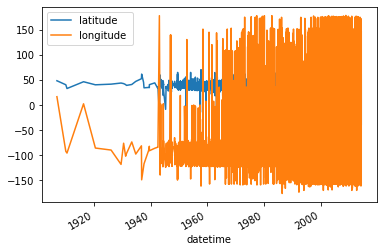

In [17]:
ufo_ts.plot()

> Hmmmm.... what are we *trying* to visualize?



In [18]:
ufo_ts.head(3)

,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
datetime,,,,,,,,,,
1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111
1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082
1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667


### What do we really want to know about UFO's? 
- Duration of sighting?
- Location of sighting?
- Number of sightings?

## Timeseries of Number of Sightings

- We want to quantify the number of events that occurred within each interval.
- What aggregratagor should we use?


In [19]:
ufo_ts.loc['January 30 1999']

,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
datetime,,,,,,,,,,
1999-01-30 05:25:00,palm springs,ca,us,sphere,10,5-10 seconds,Got up early to see the waning moon and how cl...,2/16/2000,33.830278,-116.544444
1999-01-30 17:00:00,jerusalem (israel),NaN,NaN,disk,1200,20 minutes,In early evning light the craft appeared black...,10/19/1999,31.768319,35.213710


In [20]:
## Resample as daily
ts =  ufo_ts.resample('D').size()
# ts.head()
ts

datetime
1906-11-11     1
1906-11-12     0
1906-11-13     0
1906-11-14     0
1906-11-15     0
              ..
2014-05-04     8
2014-05-05    13
2014-05-06    12
2014-05-07    13
2014-05-08     2
Freq: D, Length: 39261, dtype: int64

<AxesSubplot:xlabel='datetime'>

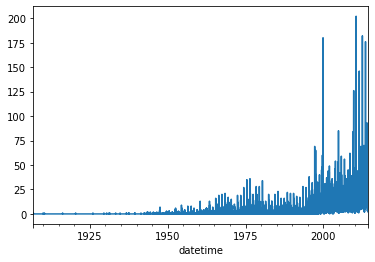

In [21]:
ts.plot()

In [26]:
## Change figsize
plt.rcParams['figure.figsize'] = [10,5]

In [ ]:
## Plot again
ts.plot();

Not much was happening before 1950.


Let's keep data from 1950 to present day

In [22]:
ts = ts.loc["1950":]
ts

datetime
1950-01-01     0
1950-01-02     1
1950-01-03     0
1950-01-04     0
1950-01-05     0
              ..
2014-05-04     8
2014-05-05    13
2014-05-06    12
2014-05-07    13
2014-05-08     2
Freq: D, Length: 23504, dtype: int64

# 🕹️Part 2) Time Series Analysis: Statistics

## 📝 **Stakeholder Questions to Answer**

**ANSWER TOGETHER:**
1) How are UFO sightings trending since 1950?


2) How Has the Total Number of UFO's Sighted Changed Over the Years?


3) How Has the Variance of UFO Sightings Changed Over the Years?


4) Is there a cycle (seasonality) to UFO sightings?  How long is the season?


5) How are different shapes of UFOs trending?

# Stakeholder Question 1: How are UFO sightings trending since 1950?

In [ ]:
## Plot the time series
ts.plot()

The plot is very noisy with some days having a large number of sightings.  Let's see if we can smooth it out some to better identify trends.  

We will take a 30 day rolling mean.

In [ ]:
## Try a rolling mean to smooth the noise
rolling_30 = ts.rolling(30).mean()
rolling_year = ts.rolling(365).mean()

rolling_30.plot()
rolling_year.plot()

## 30 Day Rolling Mean vs Monthly Frequency:

* 30 day rolling mean is still daily frequency, but each value is the average of the previous 30 days

* Monthly frequency shows the average of EACH month (Feb. 2000, March 2000, etc.)

# Stakeholder Question 2: How Has the Total Number of UFO's Sighted Changed Over the Years?

In [ ]:
## Plot a cumulative sum of sightings
ts.cumsum().plot()

# Stakeholder Question 3: How Has the Variance of UFO Sightings Changed Over the Years?

In [ ]:
## Plot the difference to find the change in variance.  Would smoothing help?
ts.diff().plot()

## Question 3b:  Can we normalize that to a percentage?

In [ ]:
## Plot percentage change instead of just raw difference
rolling_year.pct_change().plot()

### Reflection Question: Why are these plots so different?

# Stakeholder question 4: Is there a cycle (seasonality) to UFO sightings?

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

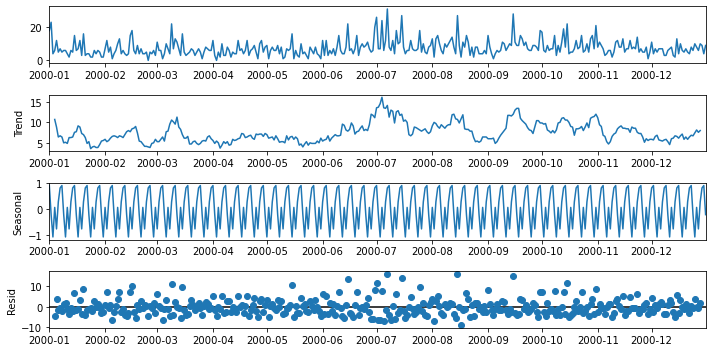

In [27]:
## Try seasonal decompose on the time series to find seasonality
results = seasonal_decompose(ts.loc['2000'])
results.plot();

## Exploring Seasonality

The above plot is not very informative.  The seasons are probably too close together to differentiate.  

We could try:

1. Zooming in to a single year or month
2. Downsampling our data to weeks, months, or years

## Zooming In:

<AxesSubplot:xlabel='datetime'>

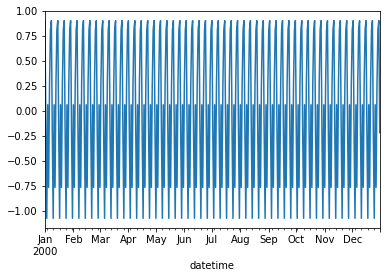

In [25]:
## Zoom in to 1 year
results.seasonal.loc['2000'].plot()

<AxesSubplot:xlabel='datetime'>

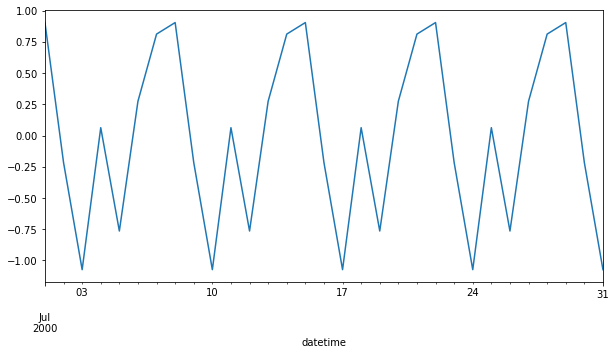

In [29]:
## Zoom in to one month
results.seasonal.loc['7/2000'].plot()

In [42]:
## Check the days of the week
days = results.seasonal.loc['7/2000'].index.day_name()

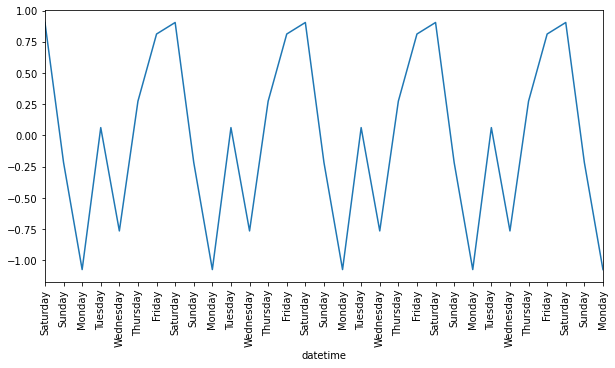

In [46]:
## Plot the seasonal series again with day names as the xticks
ix = results.seasonal.loc['7/2000'].index
results.seasonal.loc['7/2000'].plot()

# Change the xtick labels to the days of the week, rotate them 90 degrees
plt.xticks(ticks=ix, labels=days, rotation=90);

### What is the magnitude of difference at weekly seasonality?

In [48]:
results.seasonal.loc['7/2000'].max()

0.9043001816111061

In [49]:
results.seasonal.loc['7/2000'].min()

-1.0732908548034596

## Downsampling (Monthly)

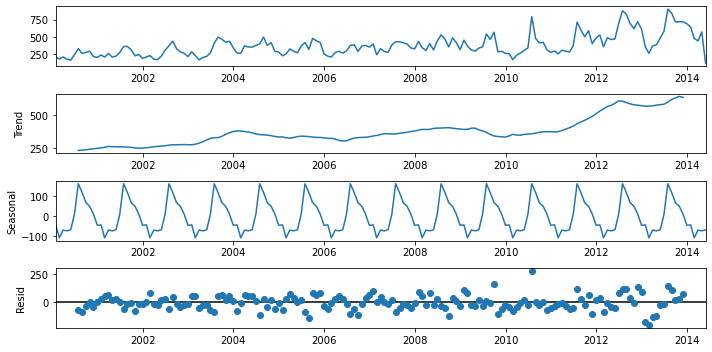

In [53]:
## Resample as monthly
m_ts = ts.resample('M').sum()

## Decompose
results = seasonal_decompose(m_ts.loc['2000':])

## Plot seasonal element
results.plot();

<AxesSubplot:xlabel='datetime'>

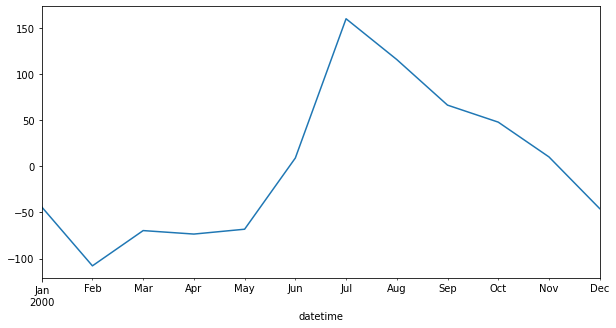

In [55]:
## Zoom in to one year
results.seasonal.loc['2000'].plot()

### What is the magnitude of difference at yearly seasonality?

# Stakeholder Question 5: How are different shapes of UFOs trending?

In [58]:
## Recheck the ufo_ts dataframe so we can pull out the shapes
ufo_ts.head(3)

,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
datetime,,,,,,,,,,
1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111
1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082
1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667


In [60]:
## Group by shape, resample to monthly, and aggregate by size
shapes = ufo_ts.groupby('shape').resample('M').size()
shapes

shape     datetime  
changed   1996-06-30     1
changing  1954-07-31     1
          1954-08-31     0
          1954-09-30     0
          1954-10-31     0
                        ..
unknown   2014-01-31    39
          2014-02-28    37
          2014-03-31    40
          2014-04-30    38
          2014-05-31     8
Length: 19344, dtype: int64

In [64]:
## Unstack the shapes
shapes_unstacked = shapes.unstack(0)
shapes_unstacked.head(3)

shape,changed,changing,chevron,cigar,circle,cone,crescent,cross,cylinder,delta,...,light,other,oval,pyramid,rectangle,round,sphere,teardrop,triangle,unknown
datetime,,,,,,,,,,,,,,,,,,,,,
1906-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1906-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1907-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
## slice out just data from after 1950
shapes_unstacked = shapes_unstacked.loc['1950':]

<AxesSubplot:xlabel='datetime'>

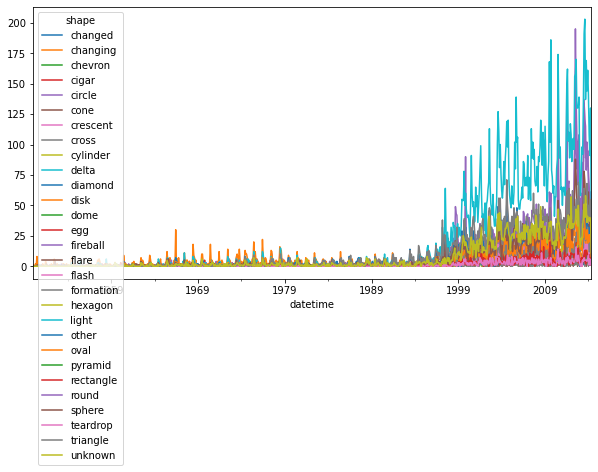

In [67]:
## Plot the shape time series
shapes_unstacked.plot()

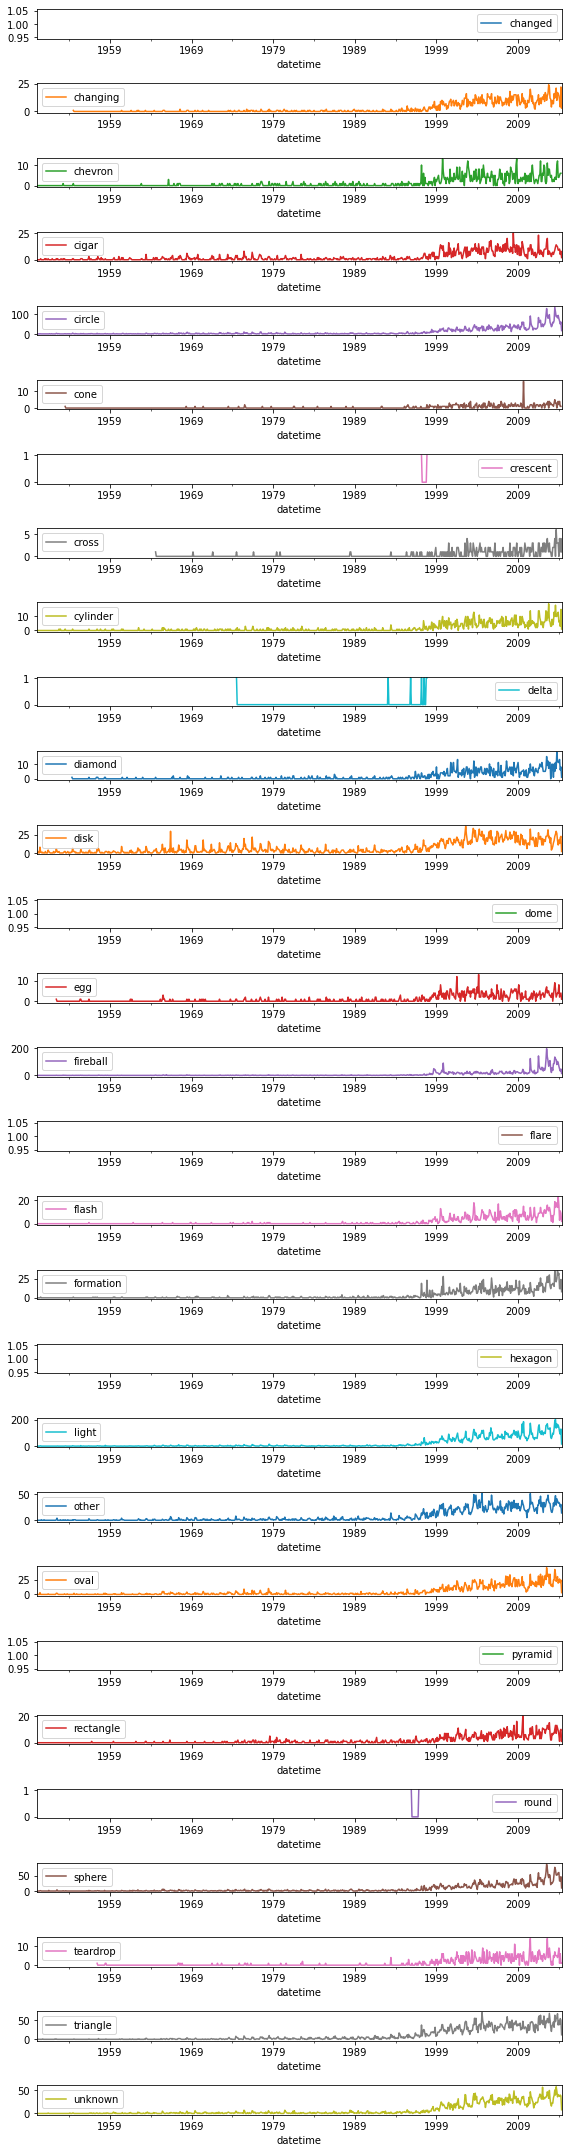

In [70]:
## Plot again, but with subplots = True
## Set sharey and sharex to False, choose a layout and try figure size (8,30)
shapes_unstacked.plot(subplots=True, sharey=False, sharex=False,
                     layout=(-1,1), figsize=(8,30))


## Set the figure to a tight layout to prevent overlapping labels
plt.tight_layout()

## 🏓**Breakout Rooms: Answering Stakeholder Questions**

**Choose 1-2 of the remaining questions and work in breakout rooms to answer them:**
- 6) What holiday has the most UFO sightings?
- 7) What day of the week has the highest reported sightings?
- 8) At what time of day (hour) do most sightings occur?
- 9) Which US state has the most sightings?
- 10) Which country had the largest proportion of sightings for the year 2000?


In [ ]:
## Make a copy of ufo_ts to play around with
eda_df = ufo_ts.copy()

### 5) Which US holiday has the largest number of sightings?

#### Feature Engineering: Holidays

In [ ]:
# !pip install holidays
import holidays
import datetime as dt
from holidays import country_holidays

In [ ]:
## Create an instance of the US country holidays.



In [ ]:
## create a test holiday 



In [ ]:
## test the api 



In [ ]:
## Saving both holidays as a column



In [ ]:
## Show unique holidays in the dataset



#### Answer to which holiday has most sightings:

In [ ]:
## Value counts of holidas



In [ ]:
## Countplot of holidays



#### Wait...when did that movie come out?

In [ ]:
release_date= '1997-07-03'

In [ ]:
## Plot the # of sightings over time and annotate the release date

## Create vertical line at '1997-05-26'



## Include a legend



### 6) What day of the week has the highest reported sightings?

In [ ]:
## create a column of day of the week names



In [ ]:
## Save the value counts of days of the week

## Create a list of the correct order of the days of the week
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
## Reorder the days of the week using .loc




In [ ]:
## Bar plot of sighting by week day



### 7) At what time of day (hour) do most sightings occur?

In [ ]:
## Add an 'hour' column to the eda_df



In [ ]:
## Get the value counts and sort the index (by hour)



In [ ]:
## Bar plot of hours of the day and sightings



### 8) Which US state has the most sightings?

In [ ]:
## Plot sightings by state



### 9) Which country had the largest proportion of sightings for the year 2000?

In [ ]:
## Plot sightings by country



# Bonus: Plotly Express

In [ ]:
import plotly.express as px
import plotly.io as pio
pio.templates

### Map Over Time

In [ ]:
eda_df.columns

In [ ]:
eda_df['year'] = eda_df.index.year
eda_df['decade'] = eda_df['year'] - eda_df['year'] % 10
eda_df = eda_df.sort_values('decade')

In [ ]:
# let's use coerce - 1 row is fine to lose
eda_df['latitude'] = pd.to_numeric(eda_df['latitude'], errors='coerce')
eda_df

In [ ]:
try:
    px.scatter_geo(data_frame=eda_df, lat='latitude',lon='longitude', animation_frame="decade")
except Exception as e:
    display(e)

In [ ]:
eda_df.columns = eda_df.columns.str.strip()
eda_df

In [ ]:
import plotly.express as px
px.scatter_geo(data_frame=eda_df, lat='latitude',lon='longitude', animation_frame="decade",
              template='ggplot2')